### Long Short Term Memory

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [2]:
returns = data['Close'].pct_change(1).dropna()

In [3]:
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [4]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [5]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

$\text{GRU}$는 평활화된 은닉 상태를 전파하기 위한 게이트 매커니즘을 제공하며, 이는 재정의될 수 있고 $\text{GRU}$를 기본 $\text{RNN}$이나 심지어 기억이 없는 Feed Forward Neural Network로 만들 수도 있다. 메모리 단위 내에서 다양한 연결을 가진 Hidden Unit을 사용한느 좀 더 복잡한 모델이 공학 문헌에서 실증적 성공을 갖고 제안됐다. $\text{LSTM}$은 $\text{GRU}$와 유사하지만 Hidden State 외에 별도의 Cell Memory인 $C_t$를 가지고 있다. 또한 $\text{LSTM}$은 메모리 업데이트가 블록 결합일 필요는 없다. 따라서 지수 평활화보다 일반적이다. $\text{LSTM}$의 수학적 설명은 직관적인 형태로 제공되는 경우는 드물지만 모델은 예를들어 Hochreiter와 Schmidhuber에서 찾을 수 있다.

Cell Memory는 forgot gate $\hat{\alpha}_t$, input gate $\hat{z}_t$와 cell gate $\hat{c}_t$와 연관된 다음의 표현식에 의해 업데이트된다.

$$c_t = \hat{\alpha}_t \circ c_{t-1} + \hat{z}_t \circ \hat{c}_t$$

$\text{LSTM}$의 언어로 $\hat{\alpha}_t, \hat{r}_t, \hat{z}_t$는 각각 forgot gate, output gate, input gate라 불린다. $\hat{z}_t = 1 - \hat{\alpha}_t$인 특수한 경우 $\text{GRU}$에서 사용된 것과 같은 유사한 지수 평활화 표현식을 얻는다. 이것을 넘어서 input gate의 역할은 필요 없으며 시계열 분석으로 논리를 피는 것도 어려운 것 같다. 유사하게 이는 단지 공학 모델의 맥락에서 나온다. 그러나 어떻게 추가적인 변수가 $\text{LSTM}$에 복잡하고 더 정교한 표현의 시간적 동학을 제공하는지 탐구할 만 하다.

Forgot gate가 $\hat{\alpha}_t = 0$일 때 Cell memory는 Cell memory date update $\hat{c}_t$에만 의존한다. $\hat{\alpha}_t \circ c_{t-1}$항에 의해 Cell memory는 $\hat{\alpha}_{t-s} = 0$이면 lag $s$를 넘어설 때에만 망각하는 long memory이다. Hidden State로 취급되고 Cell Memory와 분리된 추가 메모리는 아마다르 곱일 뿐이다.

$$\hat{h}_t = \hat{r}_t \circ \tanh(c)_t$$

여기서 $\hat{r}_t = 0$이면 재설정된다. $\hat{r}_t = 1$이면 Cell memory는 직접 hidden state를 결정한다. 따라서 reset gate는 전적으로 Cell memory의 자기회귀 구조 효과를 지우지 않고 재설정한다. 대조적으로 $\text{GRU}$는 hidden state의 역할을 하는 하나의 메모리를 갖고 있으며, 이는 reset gate에 직접 영향을 받는다. reset, forgot, input, cell memory gate는 기본 $\text{RNN}$에 의해 업데이트 되며 모두 hidden state $h_t$에 의존한다.

$$\begin{align*}
\hat{r}_t &= \sigma(U_r h_{t-1} + W_r x_t + b_r) \\ 
\hat{\alpha}_t &= \sigma(U_\alpha h_{t-1} + W_\alpha x_t + b_\alpha) \\
\hat{z}_t &= \sigma(U_z h_{t-1} + W_z x_t + b_z) \\
\hat{c}_t &= \tanh(U_c h_{t-1} + W_c x_t + b_c)
\end{align*}$$

$\text{GRU}$와 마찬가지로 $\text{LSTM}$도 간단한 $\text{RNN}$으로 작동할 수 있다. 위 식에서 $\alpha_t = 0$으로 설정하기만 하면 된다. 그러나 $\text{LSTM}$은 $\text{FFN}$의 결합으로서도 작동할 수 있다. 단지 $\hat{r}_t$로 설정하면 $h_t = 0$이므로 게이트에 순환 구조가 존재하지 않는다. 명명법이 제안하지 않더라고 $\text{GRU}$와 $\text{LSTM}$ 모두 장기 및 단기 자기회귀 메모리를 모델링할 수 있다. $\text{GRU}$는 이러한 값을 평활화된 hidden state 변수를 통해 결합한다. $\text{LSTM}$은 셀 메머리에 저장된 장기 메모리를 분리하지만 추가로 재설정될 수 있는 복사본을 사용한다. 엄밀히 말하면 Cell memory는 단기-장기 자기회귀 메모리 구조를 가지고 있기 때문에 두 개의 메뫼를 엄격히 구분하는 것은 시계열 분석의 맥락에서 오해의 소지가 있다. 후가는 전자의 절단된 버전으로 생각할 수 있다.

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [7]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 1

In [8]:
# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [9]:
dataset = torch.utils.data.TensorDataset(
    X_train_tensor, 
    y_train_tensor
)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = False
)

In [10]:
lstm = LSTM(
    input_size, 
    hidden_size, 
    output_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    lstm.parameters(), 
    lr = learning_rate
)

In [11]:
for epoch in range(num_epochs):
    lstm.train()
    optimizer.zero_grad()

    outputs = lstm(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.432685


In [12]:
lstm.eval()
with torch.no_grad():
    predicted_lstm = lstm(X_test_tensor).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

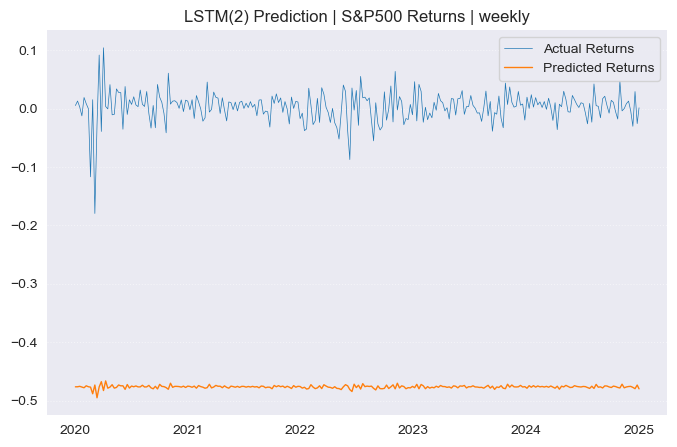

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_lstm, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'LSTM(2) Prediction | S&P500 Returns | weekly')
plt.show()